In [1]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

import pandas as pd

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import optuna

from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import make_scorer
from imblearn.ensemble import BalancedBaggingClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from src.functions.vectorize_functions import vectorize_tfidf, vectorize_glove, vectorize_w2v

#### Evaluations-Funktionen

In [4]:
def simple_evaluation(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [5]:
evaluation = pd.DataFrame(
    columns=["model", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc",
             "test_prec",
             "test_rec", "test_f1"])


def add_to_eval_df(model, model_name, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, train_acc, train_precision, train_recall,
                                             train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [6]:
evaluation_tuning = pd.DataFrame(
    columns=["model", "tuning","scorer", "best_params",
             "train_acc", "train_prec", "train_rec", "train_f1",
             "test_acc", "test_prec", "test_rec", "test_f1",
             "clf_rep_train", "clf_rep_test"])


def add_to_tuning_eval_df(model, model_name, tuning, scorer, best_params, x_data_train, y_data_train, x_data_test, y_data_test):
    pred_train = model.predict(x_data_train)
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, pred_train)
    train_recall = recall_score(y_data_train, pred_train)
    train_f1 = f1_score(y_data_train, pred_train)
    clf_rep_train = classification_report(y_data_train, pred_train)

    pred_test = model.predict(x_data_test)
    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, pred_test)
    test_recall = recall_score(y_data_test, pred_test)
    test_f1 = f1_score(y_data_test, pred_test)

    clf_rep_test = classification_report(y_data_test, pred_test)

    evaluation_tuning.loc[len(evaluation_tuning.index)] = [model_name, tuning, scorer, best_params,
                                                           train_acc, train_precision, train_recall, train_f1,
                                                           test_acc, test_precision, test_recall, test_f1,
                                                           clf_rep_test,clf_rep_test]

    evaluation_tuning.to_csv("evaluation/final_evaluation.csv")

#### Daten einlesen

In [7]:
df_train = pd.read_csv("..\\..\\..\\data\\mixed_dataset\\train_cleaned.csv", index_col=0)
df_train = df_train[df_train.tweet.notna() & df_train.tweet_cleaned.notna()]
df_train.head()

,label,tweet,tweet_cleaned,user_handle,hashtags,emojis
140232,0,"Nicki's ""that's not good"" pout bought to you b...","nickis "" good pout buy botox trade mark mkr",0,['#mkr'],__trade_mark__
6083,0,@user @user @user @user @user @user greater g...,great game ever fun possible,6,"['#fun', '#possible']",NaN
62913,0,I love that you enjoy being trans.,love enjoy tran,0,[],NaN
13525,0,yes good shapely eurotrash manbooty,yes good eurotrash,0,[],NaN
6318,0,i can't wait for euro 2016 to sta on friday #e...,wait euro sta friday euro,0,['#euro2016'],NaN


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81904 entries, 140232 to 145236
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          81904 non-null  int64 
 1   tweet          81904 non-null  object
 2   tweet_cleaned  81904 non-null  object
 3   user_handle    81904 non-null  int64 
 4   hashtags       81904 non-null  object
 5   emojis         7605 non-null   object
dtypes: int64(2), object(4)
memory usage: 4.4+ MB


#### Vergleich von Vektorisierungsarten

##### TF-IDF

In [9]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf, tfidf_vectorizer = vectorize_tfidf(df=df_train,
                                                                                 text_column="tweet_cleaned",
                                                                                 label_column="label")

##### Word2Vec

In [ ]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = vectorize_w2v(df=df_train,
                                                                 text_column="tweet_cleaned",
                                                                 label_column="label")

##### GloVe

In [ ]:
X_train_gl, X_test_gl, y_train_gl, y_test_gl = vectorize_glove(df=df_train,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

##### Vergleich der Vektorisierungsarten mit Baseline-Modell (RandomForest)

In [ ]:
rf_base_tf = RandomForestClassifier(n_jobs=-1)
rf_base_tf.fit(X_train_tf, y_train_tf)
y_pred_base_tf = rf_base_tf.predict(X_test_tf)

In [ ]:
simple_evaluation(y_test_tf, y_pred_base_tf)

In [ ]:
rf_base_w2v = RandomForestClassifier(n_jobs=-1)
rf_base_w2v.fit(X_train_w2v, y_train_w2v)
y_pred_base_w2v = rf_base_w2v.predict(X_test_w2v)

In [ ]:
simple_evaluation(y_test_w2v, y_pred_base_w2v)

In [ ]:
rf_base_gl = RandomForestClassifier(n_jobs=-1)
rf_base_gl.fit(X_train_gl, y_train_gl)
y_pred_base_gl = rf_base_gl.predict(X_test_gl)

In [ ]:
simple_evaluation(y_test_gl, y_pred_base_gl)

###### Entscheidung: TF-IDF
==> W2V und GLOVE sind beide schlechter als TF-IDF bei F1 und Recall des Targets

W2V und GLOVE werden nicht mehr betrachtet

In [10]:
X_train, X_test, y_train, y_test = X_train_tf, X_test_tf, y_train_tf, y_test_tf

In [11]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (57332, 13198)
y_train (57332,)
X_test (24572, 13198)
y_test (24572,)


#### Vergleich von Modellen ohne Hyperparamtertuning

##### RandomForestClassifier

In [ ]:
rf_base = RandomForestClassifier(n_jobs=-1)
rf_base.fit(X_train, y_train)

add_to_eval_df(model=rf_base, model_name="RandomForestClassifier", x_data_train=X_train, y_data_train=y_train,
               x_data_test=X_test, y_data_test=y_test)

##### BalancedRandomForestClassifier / BalancedBaggingClassifier (imblearn)

In [ ]:
brf_base = BalancedRandomForestClassifier(n_jobs=-1)
brf_base.fit(X_train, y_train)

add_to_eval_df(model=brf_base, model_name="BalancedRandomForestClassifier", x_data_train=X_train, y_data_train=y_train,
               x_data_test=X_test, y_data_test=y_test)

In [ ]:
brf_base_pred = brf_base.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=brf_base_pred)

In [ ]:
brf_img_base = BalancedBaggingClassifier(n_jobs=-1)
brf_img_base.fit(X_train, y_train)

add_to_eval_df(model=brf_img_base, model_name="BalancedBaggingClassifier", x_data_train=X_train, y_data_train=y_train,
               x_data_test=X_test, y_data_test=y_test)

##### XGBClassifier

In [ ]:
xgb_base = XGBClassifier(n_jobs=-1)
xgb_base.fit(X_train, y_train)

add_to_eval_df(model=xgb_base, model_name="XGBClassifier", x_data_train=X_train, y_data_train=y_train,
               x_data_test=X_test, y_data_test=y_test)

##### CatBoostClassifier

In [ ]:
cat_base = CatBoostClassifier()
cat_base.fit(X_train, y_train)

add_to_eval_df(model=cat_base, model_name="CatBoostClassifier", x_data_train=X_train, y_data_train=y_train,
               x_data_test=X_test, y_data_test=y_test)

##### LGBMClassifier

In [ ]:
lgb_base = LGBMClassifier(n_jobs=-1)
lgb_base.fit(X_train, y_train)

add_to_eval_df(model=lgb_base, model_name="LGBMClassifier", x_data_train=X_train, y_data_train=y_train,
               x_data_test=X_test, y_data_test=y_test)

##### StackingClassifier

In [ ]:
base_models_stack = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', LinearSVC(random_state=42))
]
stack_base = StackingClassifier(estimators=base_models_stack, n_jobs=-1)
stack_base.fit(X_train, y_train)

add_to_eval_df(model=stack_base, model_name="StackingClassifier", x_data_train=X_train, y_data_train=y_train,
               x_data_test=X_test, y_data_test=y_test)

##### VotingClassifier

In [ ]:
base_models_vote = [
    ('lr', LogisticRegression(random_state=42)), ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('svc', LinearSVC(random_state=42))
]

vote_base = VotingClassifier(estimators=base_models_vote, voting='hard', n_jobs=-1)
vote_base.fit(X_train, y_train)

add_to_eval_df(model=vote_base, model_name="VotingClassifier", x_data_train=X_train, y_data_train=y_train,
               x_data_test=X_test, y_data_test=y_test)

##### Vergleich der Modelle ohne Tuning

In [ ]:
evaluation.head(10)

In [ ]:
evaluation.sort_values(by=["test_f1"], ascending=False)

###### Entscheidung:

Top3 Modelle: BalancedRandomForestClassifier, CatBoostClassifier, StackingClassifier
- da BRF besser als RF, wird beim CatBoostClassifier mit Resampling gearbeitet
- StackingClassifier wird mit Anschluss an die Trainingsphase mit den besten Modellen aus Ensemble (ohne StackingClassifier), SVM und NB trainiert und in den Vergleich aufgenommen

In [12]:
resampler = SMOTE()
X_smote, y_smote = resampler.fit_resample(X_train, y_train)

In [13]:
print("X_smote", X_smote.shape)
print("y_smote", y_smote.shape)

X_smote (94008, 13198)
y_smote (94008,)


#### Hyperparametertuning ausgewählter Modelle

##### custom scorer

In [14]:
def custom_f1_macro_score(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat, average='macro')

In [15]:
def custom_f1_target_score(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat, pos_label=1)

In [16]:
custom_scorer_macro = make_scorer(custom_f1_macro_score)
custom_scorer_target = make_scorer(custom_f1_target_score)

##### Modell 1: RandomForestClassifier

###### Reference Model

In [17]:
brf_base = BalancedRandomForestClassifier(n_jobs=-1)
brf_base.fit(X_train, y_train)

BalancedRandomForestClassifier(n_jobs=-1)

In [18]:
brf_base_pred = brf_base.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=brf_base_pred)

Accuracy: 0.7561452059254435

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.76      0.84     20155
           1       0.40      0.76      0.53      4417

    accuracy                           0.76     24572
   macro avg       0.67      0.76      0.68     24572
weighted avg       0.84      0.76      0.78     24572



In [19]:
add_to_tuning_eval_df(
    model=brf_base,
    model_name="BalancedRandomForestClassifier",
    tuning="none",
    best_params="",
    scorer="none",
    x_data_train=X_train,
    y_data_train=y_train,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#1a: GridSearch

In [20]:
param_grid_brf1 = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [2, 4, 8, 16, 36, 64],
    'max_leaf_nodes': [9, 11, 13],
}

In [21]:
rs_brf1 = RandomizedSearchCV(BalancedRandomForestClassifier(n_jobs=-1),
                             param_grid_brf1,
                             scoring='f1',
                             verbose=1,
                             n_iter=10)
rs_brf1.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=BalancedRandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [2, 4, 8, 16, 36, 64],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1', verbose=1)

In [22]:
print(rs_brf1.best_estimator_)

BalancedRandomForestClassifier(max_depth=36, max_leaf_nodes=13,
                               n_estimators=150, n_jobs=-1)


In [23]:
brf_tuned1 = BalancedRandomForestClassifier(**rs_brf1.best_params_)
brf_tuned1.fit(X_train, y_train)

BalancedRandomForestClassifier(max_depth=36, max_leaf_nodes=13,
                               n_estimators=150)

In [24]:
brf_tuned1_pred = brf_tuned1.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=brf_tuned1_pred)

Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.77      0.83     20155
           1       0.39      0.66      0.49      4417

    accuracy                           0.75     24572
   macro avg       0.65      0.72      0.66     24572
weighted avg       0.82      0.75      0.77     24572



In [25]:
add_to_tuning_eval_df(
    model=brf_tuned1,
    model_name="BalancedRandomForestClassifier",
    tuning="RandomizedSearchCV",
    scorer="f1",
    best_params=rs_brf1.best_params_,
    x_data_train=X_train,
    y_data_train=y_train,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#1b: GridSearch (more param)

In [26]:
param_grid_brf2 = {
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False],
}

In [27]:
rs_brf2 = RandomizedSearchCV(BalancedRandomForestClassifier(n_jobs=-1),
                             param_grid_brf2,
                             scoring='f1',
                             verbose=1,
                             n_iter=10)
rs_brf2.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=BalancedRandomForestClassifier(n_jobs=-1),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   scoring='f1', verbose=1)

In [28]:
print(rs_brf2.best_estimator_)

BalancedRandomForestClassifier(bootstrap=False, max_depth=40,
                               max_features='auto', min_samples_leaf=2,
                               min_samples_split=10, n_estimators=500,
                               n_jobs=-1)


In [29]:
brf_tuned2 = BalancedRandomForestClassifier(**rs_brf2.best_params_)
brf_tuned2.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=False, max_depth=40,
                               max_features='auto', min_samples_leaf=2,
                               min_samples_split=10, n_estimators=500)

In [30]:
brf_tuned2_pred = brf_tuned2.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=brf_tuned2_pred)

Accuracy: 0.7660752075533127

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.78      0.85     20155
           1       0.41      0.69      0.51      4417

    accuracy                           0.77     24572
   macro avg       0.67      0.74      0.68     24572
weighted avg       0.83      0.77      0.79     24572



In [31]:
add_to_tuning_eval_df(
    model=brf_tuned2,
    model_name="BalancedRandomForestClassifier",
    tuning="RandomizedSearchCV",
    scorer="f1",
    best_params=rs_brf2.best_params_,
    x_data_train=X_train,
    y_data_train=y_train,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#1c: GridSearch (more param) + custom scorer (target f1)

In [32]:
param_grid_brf3 = {
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False],
}

In [33]:
rs_brf3 = RandomizedSearchCV(BalancedRandomForestClassifier(n_jobs=-1),
                             param_grid_brf3,
                             scoring=custom_scorer_target,
                             verbose=1,
                             n_iter=10)
rs_brf3.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=BalancedRandomForestClassifier(n_jobs=-1),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   scoring=make_scorer(custom_f1_target_score), verbose=1)

In [34]:
print(rs_brf3.best_estimator_)

BalancedRandomForestClassifier(bootstrap=False, max_features='log2',
                               min_samples_leaf=2, min_samples_split=5,
                               n_estimators=500, n_jobs=-1)


In [35]:
brf_tuned3 = BalancedRandomForestClassifier(**rs_brf3.best_params_)
brf_tuned3.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=False, max_features='log2',
                               min_samples_leaf=2, min_samples_split=5,
                               n_estimators=500)

In [36]:
brf_tuned3_pred = brf_tuned3.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=brf_tuned3_pred)

Accuracy: 0.7320934396874491

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.72      0.82     20155
           1       0.38      0.78      0.51      4417

    accuracy                           0.73     24572
   macro avg       0.66      0.75      0.66     24572
weighted avg       0.84      0.73      0.76     24572



In [37]:
add_to_tuning_eval_df(
    model=brf_tuned1,
    model_name="BalancedRandomForestClassifier",
    tuning="RandomizedSearchCV",
    scorer="target",
    best_params=rs_brf1.best_params_,
    x_data_train=X_train,
    y_data_train=y_train,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#1d: GridSearch (more param) + custom scorer (macro f1)

In [38]:
param_grid_brf4 = {
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False],
}

In [39]:
rs_brf4 = RandomizedSearchCV(BalancedRandomForestClassifier(n_jobs=-1),
                             param_grid_brf4,
                             scoring=custom_scorer_macro,
                             verbose=1,
                             n_iter=10)
rs_brf4.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=BalancedRandomForestClassifier(n_jobs=-1),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   scoring=make_scorer(custom_f1_macro_score), verbose=1)

In [40]:
print(rs_brf4.best_estimator_)

BalancedRandomForestClassifier(max_depth=20, max_features='auto',
                               min_samples_split=10, n_estimators=500,
                               n_jobs=-1)


In [41]:
brf_tuned4 = BalancedRandomForestClassifier(**rs_brf4.best_params_)
brf_tuned4.fit(X_train, y_train)

BalancedRandomForestClassifier(max_depth=20, max_features='auto',
                               min_samples_split=10, n_estimators=500)

In [42]:
brf_tuned4_pred = brf_tuned4.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=brf_tuned4_pred)

Accuracy: 0.7642845515220577

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.78      0.85     20155
           1       0.41      0.68      0.51      4417

    accuracy                           0.76     24572
   macro avg       0.66      0.73      0.68     24572
weighted avg       0.83      0.76      0.78     24572



In [43]:
add_to_tuning_eval_df(
    model=brf_tuned4,
    model_name="BalancedRandomForestClassifier",
    tuning="RandomizedSearchCV",
    scorer="f1-macro",
    best_params=rs_brf4.best_params_,
    x_data_train=X_train,
    y_data_train=y_train,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#2: optuna

In [65]:
n_trials = 50

In [66]:
def objective_brf(trial):
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=500, step=50)
    max_depth = trial.suggest_int(name="max_depth", low=10, high=100, step=5)
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=2)
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)

    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
    }

    model = BalancedRandomForestClassifier(random_state=42, **params)

    cv_score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='f1')
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy

In [67]:
sampler = TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
study_brf = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")
study_brf.optimize(objective_brf, n_trials=n_trials)

[I 2025-02-10 03:11:56,444] A new study created in memory with name: no-name-ba8ee4da-b8d0-480c-927e-0c439000812e
[I 2025-02-10 03:12:42,657] Trial 0 finished with value: 0.5101084437842094 and parameters: {'n_estimators': 250, 'max_depth': 100, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.5101084437842094.
[I 2025-02-10 03:12:53,597] Trial 1 finished with value: 0.503668128369562 and parameters: {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.5101084437842094.
[I 2025-02-10 03:13:41,331] Trial 2 finished with value: 0.5077479481311507 and parameters: {'n_estimators': 350, 'max_depth': 75, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.5101084437842094.
[I 2025-02-10 03:14:33,449] Trial 3 finished with value: 0.5082038570084959 and parameters: {'n_estimators': 450, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value

Number of finished trials: 50
Best trial:
  Value: 0.5165603713734181
  Params: 
    n_estimators: 450
    max_depth: 95
    min_samples_split: 4
    min_samples_leaf: 1


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

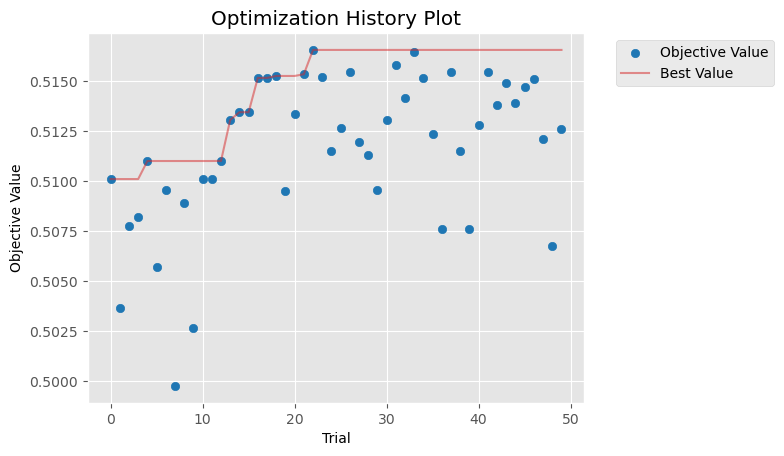

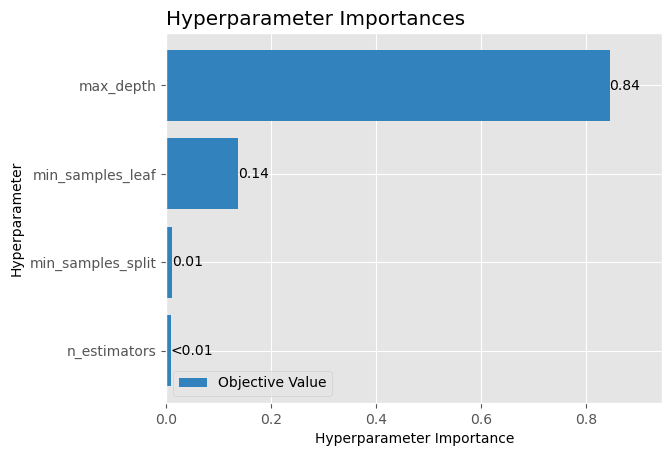

In [68]:
print("Number of finished trials: {}".format(len(study_brf.trials)))

print("Best trial:")
trial = study_brf.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

plot_optimization_history(study_brf)
plot_param_importances(study_brf)

In [69]:
brf_tuned_optuna = BalancedRandomForestClassifier(**study_brf.best_trial.params)
brf_tuned_optuna.fit(X_train, y_train)

brf_tuned_op_pred = brf_tuned_optuna.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=brf_tuned_op_pred)

Accuracy: 0.7560231157414944

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.76      0.84     20155
           1       0.40      0.73      0.52      4417

    accuracy                           0.76     24572
   macro avg       0.66      0.75      0.68     24572
weighted avg       0.83      0.76      0.78     24572



In [71]:
add_to_tuning_eval_df(
    model=brf_tuned_optuna,
    model_name="BalancedRandomForestClassifier",
    tuning="optuna",
    scorer="f1",
    best_params=study_brf.best_trial.params,
    x_data_train=X_train,
    y_data_train=y_train,
    x_data_test=X_test,
    y_data_test=y_test)

##### Modell 2: CatBoostClassifier

###### Reference Model

In [44]:
cat_base_smote = CatBoostClassifier()
cat_base_smote.fit(X_smote, y_smote)

Learning rate set to 0.071693
0:	learn: 0.6780741	total: 380ms	remaining: 6m 19s
1:	learn: 0.6644561	total: 599ms	remaining: 4m 58s
2:	learn: 0.6530456	total: 840ms	remaining: 4m 39s
3:	learn: 0.6428720	total: 1.07s	remaining: 4m 27s
4:	learn: 0.6340243	total: 1.3s	remaining: 4m 19s
5:	learn: 0.6264640	total: 1.54s	remaining: 4m 15s
6:	learn: 0.6200116	total: 1.77s	remaining: 4m 11s
7:	learn: 0.6144724	total: 2.01s	remaining: 4m 9s
8:	learn: 0.6095545	total: 2.24s	remaining: 4m 6s
9:	learn: 0.6048375	total: 2.48s	remaining: 4m 5s
10:	learn: 0.6008303	total: 2.71s	remaining: 4m 3s
11:	learn: 0.5961431	total: 2.96s	remaining: 4m 3s
12:	learn: 0.5925882	total: 3.2s	remaining: 4m 2s
13:	learn: 0.5884201	total: 3.43s	remaining: 4m 1s
14:	learn: 0.5846958	total: 3.67s	remaining: 4m
15:	learn: 0.5813987	total: 3.91s	remaining: 4m
16:	learn: 0.5781901	total: 4.15s	remaining: 4m
17:	learn: 0.5752572	total: 4.39s	remaining: 3m 59s
18:	learn: 0.5721716	total: 4.63s	remaining: 3m 58s
19:	learn: 0.

In [45]:
cat_smote_base_pred = cat_base_smote.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=cat_smote_base_pred)

Accuracy: 0.8361142764121765

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     20155
           1       0.54      0.54      0.54      4417

    accuracy                           0.84     24572
   macro avg       0.72      0.72      0.72     24572
weighted avg       0.84      0.84      0.84     24572



In [46]:
add_to_tuning_eval_df(
    model=cat_base_smote,
    model_name="CatBoostClassifier",
    tuning="none",
    scorer="none",
    best_params="",
    x_data_train=X_smote,
    y_data_train=y_smote,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#1a: RandomizedSearchCV

In [47]:
param_grid_cat1 = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.5, 1],
    'border_count': [32, 50, 100],
    'scale_pos_weight': [1, 2, 3],
    'random_seed': [42]
}

In [48]:
rs_cat1 = RandomizedSearchCV(CatBoostClassifier(),
                             param_grid_cat1,
                             scoring='f1',
                             n_jobs=-1,
                             verbose=1,
                             n_iter=10)
rs_cat1.fit(X_smote, y_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.6712149	total: 146ms	remaining: 1m 12s
1:	learn: 0.6545792	total: 289ms	remaining: 1m 11s
2:	learn: 0.6399947	total: 437ms	remaining: 1m 12s
3:	learn: 0.6303200	total: 584ms	remaining: 1m 12s
4:	learn: 0.6202319	total: 724ms	remaining: 1m 11s
5:	learn: 0.6118597	total: 868ms	remaining: 1m 11s
6:	learn: 0.6052217	total: 1.01s	remaining: 1m 11s
7:	learn: 0.5990114	total: 1.16s	remaining: 1m 11s
8:	learn: 0.5933654	total: 1.3s	remaining: 1m 11s
9:	learn: 0.5883273	total: 1.45s	remaining: 1m 10s
10:	learn: 0.5824885	total: 1.59s	remaining: 1m 10s
11:	learn: 0.5779560	total: 1.74s	remaining: 1m 10s
12:	learn: 0.5737108	total: 1.88s	remaining: 1m 10s
13:	learn: 0.5699111	total: 2.02s	remaining: 1m 10s
14:	learn: 0.5661075	total: 2.17s	remaining: 1m 10s
15:	learn: 0.5621399	total: 2.31s	remaining: 1m 9s
16:	learn: 0.5587329	total: 2.45s	remaining: 1m 9s
17:	learn: 0.5554045	total: 2.59s	remaining: 1m 9s
18:	learn: 0.5522

RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x0000024B2A9E36A0>,
                   n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 0.5, 1],
                                        'border_count': [32, 50, 100],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [100, 200, 500],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'random_seed': [42],
                                        'scale_pos_weight': [1, 2, 3]},
                   scoring='f1', verbose=1)

In [49]:
print(rs_cat1.best_estimator_)

In [50]:
cat_tuned1 = CatBoostClassifier(**rs_cat1.best_params_)
cat_tuned1.fit(X_smote, y_smote)

0:	learn: 0.6712149	total: 147ms	remaining: 1m 13s
1:	learn: 0.6545792	total: 292ms	remaining: 1m 12s
2:	learn: 0.6399947	total: 438ms	remaining: 1m 12s
3:	learn: 0.6303200	total: 585ms	remaining: 1m 12s
4:	learn: 0.6202319	total: 730ms	remaining: 1m 12s
5:	learn: 0.6118597	total: 872ms	remaining: 1m 11s
6:	learn: 0.6052217	total: 1.01s	remaining: 1m 11s
7:	learn: 0.5990114	total: 1.16s	remaining: 1m 11s
8:	learn: 0.5933654	total: 1.3s	remaining: 1m 11s
9:	learn: 0.5883273	total: 1.45s	remaining: 1m 11s
10:	learn: 0.5824885	total: 1.59s	remaining: 1m 10s
11:	learn: 0.5779560	total: 1.74s	remaining: 1m 10s
12:	learn: 0.5737108	total: 1.88s	remaining: 1m 10s
13:	learn: 0.5699111	total: 2.03s	remaining: 1m 10s
14:	learn: 0.5661075	total: 2.17s	remaining: 1m 10s
15:	learn: 0.5621399	total: 2.32s	remaining: 1m 10s
16:	learn: 0.5587329	total: 2.46s	remaining: 1m 9s
17:	learn: 0.5554045	total: 2.6s	remaining: 1m 9s
18:	learn: 0.5522585	total: 2.74s	remaining: 1m 9s
19:	learn: 0.5490818	total:

In [51]:
cat_tuned1_pred = cat_tuned1.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=cat_tuned1_pred)

Accuracy: 0.8327771447175647

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     20155
           1       0.53      0.53      0.53      4417

    accuracy                           0.83     24572
   macro avg       0.72      0.72      0.72     24572
weighted avg       0.83      0.83      0.83     24572



In [52]:
add_to_tuning_eval_df(
    model=cat_tuned1,
    model_name="CatBoostClassifier",
    tuning="RandomizedSearchCV",
    scorer="f1",
    best_params=rs_cat1.best_params_,
    x_data_train=X_smote,
    y_data_train=y_smote,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#1b: RandomizedSearchCV + custom scorer (target)

In [53]:
param_grid_cat2 = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.5, 1],
    'border_count': [32, 50, 100],
    'scale_pos_weight': [1, 2, 3],
    'random_seed': [42]
}

In [54]:
rs_cat2 = RandomizedSearchCV(CatBoostClassifier(),
                             param_grid_cat2,
                             scoring=custom_scorer_target,
                             n_jobs=-1,
                             verbose=1,
                             n_iter=10)
rs_cat2.fit(X_smote, y_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.6341169	total: 162ms	remaining: 1m 20s
1:	learn: 0.6033964	total: 310ms	remaining: 1m 17s
2:	learn: 0.5809960	total: 468ms	remaining: 1m 17s
3:	learn: 0.5657013	total: 630ms	remaining: 1m 18s
4:	learn: 0.5531113	total: 784ms	remaining: 1m 17s
5:	learn: 0.5426274	total: 935ms	remaining: 1m 16s
6:	learn: 0.5306834	total: 1.08s	remaining: 1m 16s
7:	learn: 0.5220980	total: 1.23s	remaining: 1m 15s
8:	learn: 0.5163134	total: 1.38s	remaining: 1m 15s
9:	learn: 0.5109414	total: 1.53s	remaining: 1m 14s
10:	learn: 0.5071055	total: 1.67s	remaining: 1m 14s
11:	learn: 0.5034565	total: 1.82s	remaining: 1m 14s
12:	learn: 0.4935217	total: 1.97s	remaining: 1m 13s
13:	learn: 0.4878947	total: 2.11s	remaining: 1m 13s
14:	learn: 0.4854139	total: 2.26s	remaining: 1m 13s
15:	learn: 0.4807458	total: 2.41s	remaining: 1m 12s
16:	learn: 0.4775355	total: 2.56s	remaining: 1m 12s
17:	learn: 0.4747739	total: 2.7s	remaining: 1m 12s
18:	learn: 0.4

RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x0000024B2A9E2890>,
                   n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 0.5, 1],
                                        'border_count': [32, 50, 100],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [100, 200, 500],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'random_seed': [42],
                                        'scale_pos_weight': [1, 2, 3]},
                   scoring=make_scorer(custom_f1_target_score), verbose=1)

In [55]:
print(rs_cat2.best_estimator_)

In [56]:
cat_tuned2 = CatBoostClassifier(**rs_cat2.best_params_)
cat_tuned2.fit(X_smote, y_smote)

0:	learn: 0.6341169	total: 148ms	remaining: 1m 13s
1:	learn: 0.6033964	total: 289ms	remaining: 1m 12s
2:	learn: 0.5809960	total: 434ms	remaining: 1m 11s
3:	learn: 0.5657013	total: 579ms	remaining: 1m 11s
4:	learn: 0.5531113	total: 722ms	remaining: 1m 11s
5:	learn: 0.5426274	total: 867ms	remaining: 1m 11s
6:	learn: 0.5306834	total: 1.01s	remaining: 1m 11s
7:	learn: 0.5220980	total: 1.16s	remaining: 1m 11s
8:	learn: 0.5163134	total: 1.3s	remaining: 1m 10s
9:	learn: 0.5109414	total: 1.44s	remaining: 1m 10s
10:	learn: 0.5071055	total: 1.58s	remaining: 1m 10s
11:	learn: 0.5034565	total: 1.73s	remaining: 1m 10s
12:	learn: 0.4935217	total: 1.87s	remaining: 1m 10s
13:	learn: 0.4878947	total: 2.01s	remaining: 1m 9s
14:	learn: 0.4854139	total: 2.15s	remaining: 1m 9s
15:	learn: 0.4807458	total: 2.3s	remaining: 1m 9s
16:	learn: 0.4775355	total: 2.44s	remaining: 1m 9s
17:	learn: 0.4747739	total: 2.58s	remaining: 1m 9s
18:	learn: 0.4725776	total: 2.73s	remaining: 1m 9s
19:	learn: 0.4691585	total: 2.

In [57]:
cat_tuned2_pred = cat_tuned2.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=cat_tuned2_pred)

Accuracy: 0.7928536545661728

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     20155
           1       0.45      0.67      0.54      4417

    accuracy                           0.79     24572
   macro avg       0.68      0.74      0.70     24572
weighted avg       0.83      0.79      0.81     24572



In [58]:
add_to_tuning_eval_df(
    model=cat_tuned2,
    model_name="CatBoostClassifier",
    tuning="RandomizedSearchCV",
    scorer="target",
    best_params=rs_cat2.best_params_,
    x_data_train=X_smote,
    y_data_train=y_smote,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#1c: RandomizedSearchCV + custom scorer (macro f1)

In [59]:
param_grid_cat3 = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.5, 1],
    'border_count': [32, 50, 100],
    'scale_pos_weight': [1, 2, 3],
    'random_seed': [42]
}

In [60]:
rs_cat3 = RandomizedSearchCV(CatBoostClassifier(),
                             param_grid_cat3,
                             scoring=custom_scorer_macro,
                             n_jobs=-1,
                             verbose=1,
                             n_iter=10)
rs_cat3.fit(X_smote, y_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.6888711	total: 358ms	remaining: 35.5s
1:	learn: 0.6842891	total: 683ms	remaining: 33.5s
2:	learn: 0.6798376	total: 1.01s	remaining: 32.8s
3:	learn: 0.6762802	total: 1.35s	remaining: 32.5s
4:	learn: 0.6731853	total: 1.68s	remaining: 32s
5:	learn: 0.6699669	total: 2.01s	remaining: 31.5s
6:	learn: 0.6664799	total: 2.36s	remaining: 31.3s
7:	learn: 0.6632820	total: 2.69s	remaining: 31s
8:	learn: 0.6593101	total: 3.02s	remaining: 30.6s
9:	learn: 0.6551896	total: 3.36s	remaining: 30.3s
10:	learn: 0.6517354	total: 3.69s	remaining: 29.9s
11:	learn: 0.6487008	total: 4.02s	remaining: 29.5s
12:	learn: 0.6457890	total: 4.35s	remaining: 29.1s
13:	learn: 0.6425315	total: 4.7s	remaining: 28.9s
14:	learn: 0.6401907	total: 5.04s	remaining: 28.6s
15:	learn: 0.6368459	total: 5.39s	remaining: 28.3s
16:	learn: 0.6336924	total: 5.75s	remaining: 28s
17:	learn: 0.6307866	total: 6.08s	remaining: 27.7s
18:	learn: 0.6275782	total: 6.42s	rema

RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x0000024B67E363B0>,
                   n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 0.5, 1],
                                        'border_count': [32, 50, 100],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [100, 200, 500],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'random_seed': [42],
                                        'scale_pos_weight': [1, 2, 3]},
                   scoring=make_scorer(custom_f1_macro_score), verbose=1)

In [61]:
print(rs_cat3.best_estimator_)

In [62]:
cat_tuned3 = CatBoostClassifier(**rs_cat3.best_params_)
cat_tuned3.fit(X_smote, y_smote)

0:	learn: 0.6888711	total: 365ms	remaining: 36.1s
1:	learn: 0.6842891	total: 690ms	remaining: 33.8s
2:	learn: 0.6798376	total: 1.02s	remaining: 32.9s
3:	learn: 0.6762802	total: 1.34s	remaining: 32.3s
4:	learn: 0.6731853	total: 1.67s	remaining: 31.7s
5:	learn: 0.6699669	total: 2s	remaining: 31.3s
6:	learn: 0.6664799	total: 2.32s	remaining: 30.8s
7:	learn: 0.6632820	total: 2.65s	remaining: 30.5s
8:	learn: 0.6593101	total: 2.98s	remaining: 30.2s
9:	learn: 0.6551896	total: 3.31s	remaining: 29.8s
10:	learn: 0.6517354	total: 3.64s	remaining: 29.4s
11:	learn: 0.6487008	total: 3.97s	remaining: 29.1s
12:	learn: 0.6457890	total: 4.3s	remaining: 28.8s
13:	learn: 0.6425315	total: 4.62s	remaining: 28.4s
14:	learn: 0.6401907	total: 4.95s	remaining: 28.1s
15:	learn: 0.6368459	total: 5.28s	remaining: 27.7s
16:	learn: 0.6336924	total: 5.62s	remaining: 27.4s
17:	learn: 0.6307866	total: 5.95s	remaining: 27.1s
18:	learn: 0.6275782	total: 6.28s	remaining: 26.8s
19:	learn: 0.6245958	total: 6.61s	remaining: 

In [63]:
cat_tuned3_pred = cat_tuned3.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=cat_tuned3_pred)

Accuracy: 0.22318085625915676

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.05      0.10     20155
           1       0.19      1.00      0.32      4417

    accuracy                           0.22     24572
   macro avg       0.59      0.53      0.21     24572
weighted avg       0.84      0.22      0.14     24572



In [64]:
add_to_tuning_eval_df(
    model=cat_tuned3,
    model_name="CatBoostClassifier",
    tuning="RandomizedSearchCV",
    scorer="f1-macro",
    best_params=rs_cat3.best_params_,
    x_data_train=X_smote,
    y_data_train=y_smote,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#2: optuna

In [72]:
n_trials = 50

In [73]:
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_uniform('random_strength', 1.0, 10.0),
        'early_stopping_rounds': 50,
        'eval_metric': 'F1'
    }

    model = CatBoostClassifier(random_state=42, **params)

    cv_score = cross_val_score(model, X_smote, y_smote, n_jobs=-1, cv=5, scoring='f1')
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy

In [74]:
sampler = TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
study_cat = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")
study_cat.optimize(objective_cat, n_trials=n_trials)

[I 2025-02-10 07:41:46,929] A new study created in memory with name: no-name-b6d6f179-3263-41a9-b6a2-3dc5ad1b624b
[W 2025-02-10 08:01:58,156] Trial 0 failed with parameters: {'iterations': 437, 'learning_rate': 0.566984951147885, 'depth': 9, 'l2_leaf_reg': 0.039079671568228794, 'border_count': 66, 'bagging_temperature': 0.15599452033620265, 'random_strength': 1.5227525095137953} because of the following error: The value nan is not acceptable.
[W 2025-02-10 08:01:58,157] Trial 0 failed with value nan.
[I 2025-02-10 08:43:33,735] Trial 1 finished with value: 0.7772255247555776 and parameters: {'iterations': 880, 'learning_rate': 0.010129197956845729, 'depth': 8, 'l2_leaf_reg': 1.3289448722869181e-05, 'border_count': 249, 'bagging_temperature': 0.8324426408004217, 'random_strength': 2.9110519961044856}. Best is trial 1 with value: 0.7772255247555776.
[I 2025-02-10 08:46:19,542] Trial 2 finished with value: 0.5021258135891248 and parameters: {'iterations': 263, 'learning_rate': 8.260808399

Number of finished trials: 50
Best trial:
  Value: 0.5165603713734181
  Params: 
    iterations: 699
    learning_rate: 0.2175472690865774
    depth: 10
    l2_leaf_reg: 0.0017156647398932556
    border_count: 84
    bagging_temperature: 0.4852222509763763
    random_strength: 2.04560389329633


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

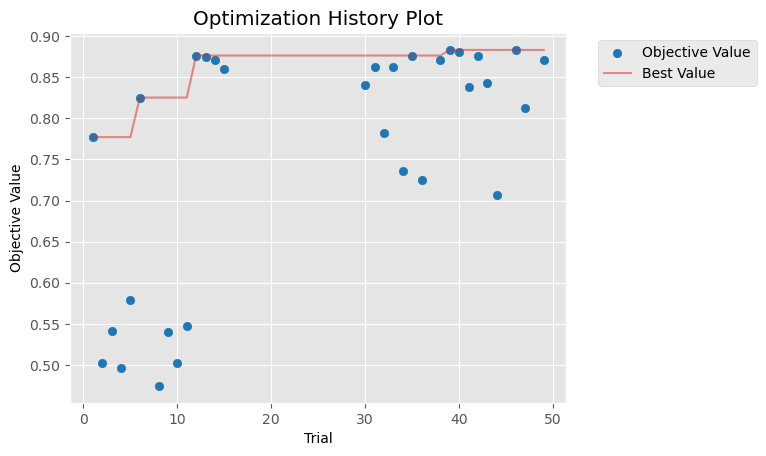

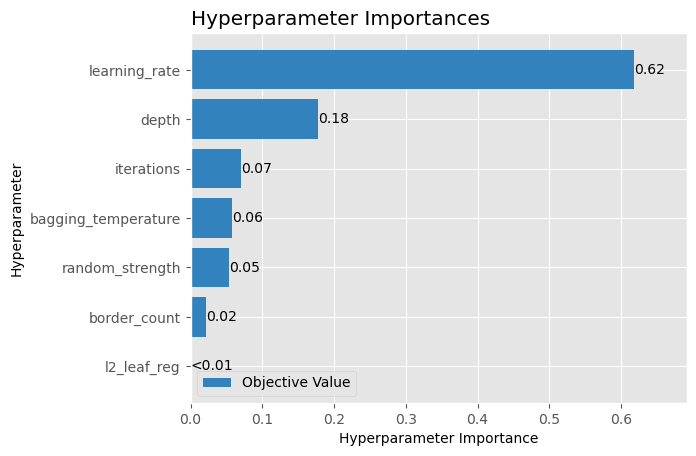

In [75]:
print("Number of finished trials: {}".format(len(study_cat.trials)))

print("Best trial:")
trial_cat = study_cat.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial_cat.params.items():
    print("    {}: {}".format(key, value))

plot_optimization_history(study_cat)
plot_param_importances(study_cat)

In [77]:
cat_tuned_optuna = CatBoostClassifier(**study_cat.best_trial.params)
cat_tuned_optuna.fit(X_train, y_train)

cat_tuned_op_pred = cat_tuned_optuna.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=cat_tuned_op_pred)

0:	learn: 0.6010741	total: 3.4s	remaining: 39m 31s
1:	learn: 0.5363718	total: 6.35s	remaining: 36m 53s
2:	learn: 0.5009437	total: 9.3s	remaining: 35m 57s
3:	learn: 0.4799010	total: 11.2s	remaining: 32m 23s
4:	learn: 0.4625268	total: 13.1s	remaining: 30m 18s
5:	learn: 0.4510549	total: 15s	remaining: 28m 50s
6:	learn: 0.4428946	total: 17.1s	remaining: 28m 14s
7:	learn: 0.4331830	total: 20.5s	remaining: 29m 33s
8:	learn: 0.4271886	total: 24s	remaining: 30m 39s
9:	learn: 0.4229741	total: 26.5s	remaining: 30m 27s
10:	learn: 0.4195417	total: 28.4s	remaining: 29m 38s
11:	learn: 0.4153334	total: 30.5s	remaining: 29m 4s
12:	learn: 0.4130670	total: 32.4s	remaining: 28m 30s
13:	learn: 0.4104834	total: 34.4s	remaining: 28m 1s
14:	learn: 0.4087978	total: 36.3s	remaining: 27m 35s
15:	learn: 0.4065080	total: 38.3s	remaining: 27m 14s
16:	learn: 0.4044491	total: 40.2s	remaining: 26m 52s
17:	learn: 0.4027660	total: 42.1s	remaining: 26m 33s
18:	learn: 0.4012337	total: 44.7s	remaining: 26m 41s
19:	learn: 

In [78]:
add_to_tuning_eval_df(
    model=cat_tuned_optuna,
    model_name="CatBoostClassifier",
    tuning="optuna",
    scorer="f1",
    best_params=study_cat.best_trial.params,
    x_data_train=X_smote,
    y_data_train=y_smote,
    x_data_test=X_test,
    y_data_test=y_test)

##### Modell 3: StackingClassifier

In [ ]:
# base_models_stack = [
#     ('rf', RandomForestClassifier(random_state=42)),
#     ('svc', LinearSVC(random_state=42))
# ]

In [ ]:

# stack_base = StackingClassifier(estimators=base_models_stack, n_jobs=-1)
# stack_base.fit(X_train, y_train)
#
# add_to_eval_df(model=stack_base, model_name="StackingClassifier", x_data_train=X_train, y_data_train=y_train,
#                x_data_test=X_test, y_data_test=y_test)

#### Model Comparison

In [79]:
evaluation_tuning

,model,tuning,scorer,best_params,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1,clf_rep_train,clf_rep_test
0,BalancedRandomForestClassifier,none,none,,0.859311,0.561494,0.999903,0.719150,0.756145,0.404811,0.758207,0.527817,precision recall f1-score ...,precision recall f1-score ...
1,BalancedRandomForestClassifier,RandomizedSearchCV,f1,"{'n_estimators': 150, 'max_leaf_nodes': 13, 'm...",0.756959,0.397940,0.680674,0.502250,0.750000,0.386268,0.663573,0.488297,precision recall f1-score ...,precision recall f1-score ...
2,BalancedRandomForestClassifier,RandomizedSearchCV,f1,"{'n_estimators': 500, 'min_samples_split': 10,...",0.786925,0.444320,0.729376,0.552232,0.766075,0.410370,0.689835,0.514609,precision recall f1-score ...,precision recall f1-score ...
3,BalancedRandomForestClassifier,RandomizedSearchCV,target,"{'n_estimators': 150, 'max_leaf_nodes': 13, 'm...",0.756959,0.397940,0.680674,0.502250,0.750000,0.386268,0.663573,0.488297,precision recall f1-score ...,precision recall f1-score ...
4,BalancedRandomForestClassifier,RandomizedSearchCV,f1-macro,"{'n_estimators': 500, 'min_samples_split': 10,...",0.782914,0.437092,0.712432,0.541786,0.764285,0.406501,0.676704,0.507901,precision recall f1-score ...,precision recall f1-score ...
5,CatBoostClassifier,none,none,,0.890648,0.914604,0.861756,0.887394,0.836114,0.544848,0.536337,0.540559,precision recall f1-score ...,precision recall f1-score ...
6,CatBoostClassifier,RandomizedSearchCV,f1,"{'scale_pos_weight': 1, 'random_seed': 42, 'le...",0.876170,0.903586,0.842205,0.871816,0.832777,0.534921,0.534073,0.534496,precision recall f1-score ...,precision recall f1-score ...
7,CatBoostClassifier,RandomizedSearchCV,target,"{'scale_pos_weight': 2, 'random_seed': 42, 'le...",0.900200,0.864371,0.949366,0.904877,0.792854,0.448946,0.669912,0.537609,precision recall f1-score ...,precision recall f1-score ...
8,CatBoostClassifier,RandomizedSearchCV,f1-macro,"{'scale_pos_weight': 3, 'random_seed': 42, 'le...",0.528870,0.514888,0.998426,0.679406,0.223181,0.187519,0.996604,0.315646,precision recall f1-score ...,precision recall f1-score ...
9,BalancedRandomForestClassifier,optuna,f1,"{'n_estimators': 450, 'max_depth': 95, 'min_sa...",0.813455,0.489633,0.839175,0.618431,0.756023,0.401768,0.730586,0.518435,precision recall f1-score ...,precision recall f1-score ...


In [81]:
evaluation_tuning.sort_values(by=["test_f1"], ascending=False)

,model,tuning,scorer,best_params,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1,clf_rep_train,clf_rep_test
5,CatBoostClassifier,none,none,,0.890648,0.914604,0.861756,0.887394,0.836114,0.544848,0.536337,0.540559,precision recall f1-score ...,precision recall f1-score ...
7,CatBoostClassifier,RandomizedSearchCV,target,"{'scale_pos_weight': 2, 'random_seed': 42, 'le...",0.900200,0.864371,0.949366,0.904877,0.792854,0.448946,0.669912,0.537609,precision recall f1-score ...,precision recall f1-score ...
6,CatBoostClassifier,RandomizedSearchCV,f1,"{'scale_pos_weight': 1, 'random_seed': 42, 'le...",0.876170,0.903586,0.842205,0.871816,0.832777,0.534921,0.534073,0.534496,precision recall f1-score ...,precision recall f1-score ...
0,BalancedRandomForestClassifier,none,none,,0.859311,0.561494,0.999903,0.719150,0.756145,0.404811,0.758207,0.527817,precision recall f1-score ...,precision recall f1-score ...
9,BalancedRandomForestClassifier,optuna,f1,"{'n_estimators': 450, 'max_depth': 95, 'min_sa...",0.813455,0.489633,0.839175,0.618431,0.756023,0.401768,0.730586,0.518435,precision recall f1-score ...,precision recall f1-score ...
2,BalancedRandomForestClassifier,RandomizedSearchCV,f1,"{'n_estimators': 500, 'min_samples_split': 10,...",0.786925,0.444320,0.729376,0.552232,0.766075,0.410370,0.689835,0.514609,precision recall f1-score ...,precision recall f1-score ...
4,BalancedRandomForestClassifier,RandomizedSearchCV,f1-macro,"{'n_estimators': 500, 'min_samples_split': 10,...",0.782914,0.437092,0.712432,0.541786,0.764285,0.406501,0.676704,0.507901,precision recall f1-score ...,precision recall f1-score ...
1,BalancedRandomForestClassifier,RandomizedSearchCV,f1,"{'n_estimators': 150, 'max_leaf_nodes': 13, 'm...",0.756959,0.397940,0.680674,0.502250,0.750000,0.386268,0.663573,0.488297,precision recall f1-score ...,precision recall f1-score ...
3,BalancedRandomForestClassifier,RandomizedSearchCV,target,"{'n_estimators': 150, 'max_leaf_nodes': 13, 'm...",0.756959,0.397940,0.680674,0.502250,0.750000,0.386268,0.663573,0.488297,precision recall f1-score ...,precision recall f1-score ...
10,CatBoostClassifier,optuna,f1,"{'iterations': 699, 'learning_rate': 0.2175472...",0.840503,0.995051,0.684410,0.811002,0.843399,0.602671,0.378085,0.464663,precision recall f1-score ...,precision recall f1-score ...


#### Top 2 Models (tuned)

In [ ]:
df_test = pd.read_csv("..\\..\\..\\data\\mixed_dataset\\test_cleaned.csv", index_col=0)
df_test = df_test[df_test.tweet.notna() & df_test.tweet_cleaned.notna()]
df_train.head()

In [ ]:
X_test_final = df_test["tweet_cleaned"]
y_test_final = df_test["label"]

In [ ]:
X_test_final = tfidf_vectorizer.transform(X_test_final)

##### Model evaluation

In [ ]:
final_evaluation_tuning = pd.DataFrame(
    columns=["model", "tuning","scorer", "best_params",
             "train_acc", "train_prec", "train_rec", "train_f1",
             "val_acc", "val_prec", "val_rec", "val_f1",
             "test_acc", "test_prec", "test_rec", "test_f1",
             "clf_rep_train", "clf_rep_val", "clf_rep_test"])


def add_to_final_eval_df(model, model_name, tuning, scorer, best_params, x_data_train, y_data_train, x_data_val, y_data_val, x_data_test, y_data_test):
    pred_train = model.predict(x_data_train)
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, pred_train)
    train_recall = recall_score(y_data_train, pred_train)
    train_f1 = f1_score(y_data_train, pred_train)
    clf_rep_train = classification_report(y_data_train, pred_train)

    pred_test = model.predict(x_data_test)
    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, pred_test)
    test_recall = recall_score(y_data_test, pred_test)
    test_f1 = f1_score(y_data_test, pred_test)
    clf_rep_test = classification_report(y_data_test, pred_test)

    evaluation_tuning.loc[len(evaluation_tuning.index)] = [model_name, tuning, scorer, best_params,
                                                           train_acc, train_precision, train_recall, train_f1,
                                                           test_acc, test_precision, test_recall, test_f1,
                                                           clf_rep_test,clf_rep_test]

    evaluation_tuning.to_csv("evaluation/final_evaluation.csv")

##### Top-Model#1:

##### Top-Model#2: